In [1]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [2]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [3]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [4]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [5]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [6]:
#lets save the mapper for later use
with open('models/data/lookup_table', 'wb') as fp:
    pickle.dump(lookup_table, fp)

In [7]:
#lets check lookup table
with open ('models/data/lookup_table', 'rb') as fp:
    lut_load = pickle.load(fp)

#lut_load

In [8]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

with open('models/data/val_idx', 'wb') as fp:
    pickle.dump(val_idx, fp)
    
with open('models/data/ratings', 'wb') as fp:
    pickle.dump(y, fp)

In [9]:
#final df , everything is numeric and continguous
with open('models/data/final_df', 'wb') as fp:
    pickle.dump(df, fp)

In [10]:
df.head(10)

,user,course,category,job,institution,state
104079,33432,171,7,6,14,39
74593,20679,175,7,6,9,35
28945,49486,28,7,6,11,51
152312,3097,14,9,3,11,24
90958,34753,174,7,6,9,23
51690,1757,64,7,6,0,45
31710,47553,44,7,6,2,24
135543,8604,3,1,6,14,28
112632,26424,71,8,6,0,45
154349,15584,43,8,6,6,24


In [11]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [12]:
#build embedding matrix, matrices should be bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1000) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
with open('models/data/emb_sizes', 'wb') as fp:
    pickle.dump(emb_szs, fp)

In [13]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.5, 1, [100,50], [0.5,0.01],y_range=(0,5))

In [14]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 2655850)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 60950)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 50700)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 52250)])),
             ('Embedding-5',
              OrderedDict([('inpu

In [15]:
#lets find a learning rate
m.lr_find()

epoch      trn_loss   val_loss                                
    0      1.270814   1.277553  



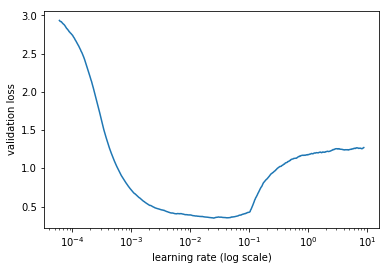

In [16]:
m.sched.plot(100)

In [17]:
lr = 1e-3

In [18]:
# Local
#m.fit(lr, 2, cycle_len=2)

In [19]:
# GPU
# lets fit the model, 10 epochs with restarts
m.fit(lr, 10, cycle_len=1, wds=1e-3)

epoch      trn_loss   val_loss                                
    0      0.268506   0.255554  
    1      0.234577   0.226035                                
    2      0.198637   0.223214                                
    3      0.194547   0.223632                                
    4      0.195265   0.22416                                 
    5      0.183143   0.224411                                
    6      0.186299   0.224348                                
    7      0.182715   0.222204                                
    8      0.182431   0.221946                                
    9      0.176393   0.223074                                



[array([0.22307])]

In [20]:
m.save('mdl')

In [21]:
m.load('mdl')

In [22]:
x,y=m.predict_with_targs()

In [23]:
pred_test=m.predict(is_test=True)

In [24]:
joined_test['rating_pred'] = pred_test

In [25]:
joined_test[['rating','rating_pred']].head(10)

,rating,rating_pred
107105,4.00,4.057054
59735,4.27,4.302510
87192,4.65,4.568114
67528,4.08,3.987086
33861,3.69,3.921203
172387,4.68,3.986476
14755,4.19,4.137742
84292,4.08,4.165675
125747,3.77,3.827272
169576,4.59,4.532988


In [26]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [27]:
# we achieved a root mean squared error of .47
rms

0.47006516337137877

In [28]:
test_record = df_test.iloc[0]

In [29]:
joined_test.iloc[0]

user              4313
course              15
category             7
rating               4
job                  6
institution         14
state                8
rating_pred    4.05705
Name: 107105, dtype: object

In [30]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [31]:
prediction[0][0]

4.057054

In [32]:
#model is ready, need to create simple api and also test with new data since the original was pulled

In [33]:
# lets load up the test set

In [34]:
post_test = pd.read_csv('test_ratings.csv')

In [35]:
for v in cat_vars: 
    post_test[v] = post_test[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    post_test[v] = post_test[v].fillna(0).astype('float32')

In [36]:
course_extras = {}
user_extras = {}
unknown_user = df['user'].max() + 1
unknown_course = df['course'].max() + 1

def look_course_up(x):
    global unknown_course
    global course_extras
    
    try:
        val = lookup_table['course'][x]
    except KeyError:
        # user is not there, lets set to unknown
        # lets check extras
        try:
            val = course_extras[x]
        except KeyError:
            # so we really dont have it, set to unknown
            val = unknown_course
            course_extras[x] = unknown_course
            unknown_course = unknown_course + 1
    return val

def look_user_up(x):
    global unknown_user
    global user_extras
    try:
        val = lookup_table['user'][x]
    except KeyError:
        # user is not there, lets set to unknown
        # lets check extras
        try:
            val = user_extras[x]
        except KeyError:
            # so we really dont have it, set to unknown
            val = unknown_user
            user_extras[x] = unknown_user
            unknown_user = unknown_user + 1
    return val

In [37]:
unknown_user

52117

In [38]:
#unknown_course
#unknown_user
#luu = look_user_up('01e15a509a7a66df61edc488557456cc5e937c9c949c99517e3ec080938ec3e388b8522eccf7914f9760d6301b0f1d2a6927bee2b510d8716eb3f4bcad2e24c3')

In [39]:
test_vars = ['category','job','institution','state']

for c in test_vars:
    col2idx =  lookup_table[c]
    post_test[c] = post_test[c].apply(lambda x: col2idx[x])

In [40]:
post_test['user'] = post_test['user'].apply(look_user_up)
post_test['course'] = post_test['course'].apply(look_course_up)

In [41]:
post_test

,user,course,category,rating,job,institution,state
0,38762,71,8,4.05,29,0,41
1,31857,37,8,3.23,6,0,41
2,24228,37,8,3.77,6,0,41
3,12717,44,7,4.59,6,9,57
4,1599,63,9,3.73,6,14,39
5,20543,186,9,2.82,6,9,41
6,20543,177,7,3.73,6,9,41
7,20543,38,7,3.73,6,9,41
8,36724,203,7,4.77,6,2,41
9,16321,174,7,3.73,6,14,41


In [1]:
# lets make a function to get the rating

In [42]:
def get_rating(df):
    cat = df[cat_vars].values.astype(np.int64)[None]
    prediction = to_np(model(V(cat),[]))
    return prediction[0][0]

In [3]:
#mrating = get_rating(post_test.iloc[0])

In [44]:
post_test['prating'] = post_test.apply(get_rating, axis=1)

In [45]:
post_test.head(10)

,user,course,category,rating,job,institution,state,prating
0,38762,71,8,4.05,29,0,41,3.707968
1,31857,37,8,3.23,6,0,41,3.636474
2,24228,37,8,3.77,6,0,41,3.811103
3,12717,44,7,4.59,6,9,57,4.475251
4,1599,63,9,3.73,6,14,39,3.703550
5,20543,186,9,2.82,6,9,41,3.875622
6,20543,177,7,3.73,6,9,41,3.924339
7,20543,38,7,3.73,6,9,41,3.895814
8,36724,203,7,4.77,6,2,41,4.200868
9,16321,174,7,3.73,6,14,41,3.872567


In [46]:
rms_pt = sqrt(mean_squared_error(post_test['rating'], post_test['prating']))

In [47]:
rms_pt

0.5132613564108592

In [2]:
# rmse on live, unknown data is close to our training data, this tells me the model is good